# ${}^{4}{\rm He}$

The interaction is defined in `helium4.py`. It is nonlocal, and so is the counterterm. We will use it to tune the scattering length, $a_0$, **and** the effective range, $r_0$, over a range of short-distance cutoffs, $R$.

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

import helium4 as he4

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
ELL = 0
Rs, lo_gs = np.loadtxt('datfiles/he4_LO_nonlocal_rg_flow.txt', unpack=True)
nR = Rs.size
g_los = np.empty(nR)
g_nlos = np.empty(nR)
b2s = np.empty(nR)

In [63]:
momenta = np.linspace(0.01/he4.BETA6, 0.3/he4.BETA6, 30)
X = he4.FACTOR * he4.BETA6 # K•Å^3
KCD = -1/he4.A0 + he4.R0/2*momenta**2

# First, we will tune k(cot(delta)). Then we'll go back and refine a_0 and r_0.
def kcd_diff(gpair, sys):
    kcd = sys.kcotd_gen_fast(momenta, *gpair)
    return np.sum(((KCD - kcd)/KCD)**2)


def inverse_a0_diff(gi, gj, sys):
    a0, _ = sys.a0_and_r0(gi, gj, momenta, use_c=True)
    return (1/he4.A0 - 1/a0)*he4.A0

In [64]:
s = he4.construct_helium4_system(Rs[0], ELL)

In [80]:
g_nlo_test = np.linspace(100, 500, 20)*X
test_results = []
guess = lo_gs[0]

for gj in g_nlo_test:
    result = optimize.fsolve(inverse_a0_diff, guess, args=(gj, s))
    test_results.append(s.a0_and_r0(result[0], gj, momenta, use_c=True))
    guess = result[0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [81]:
test_results = np.array(test_results)

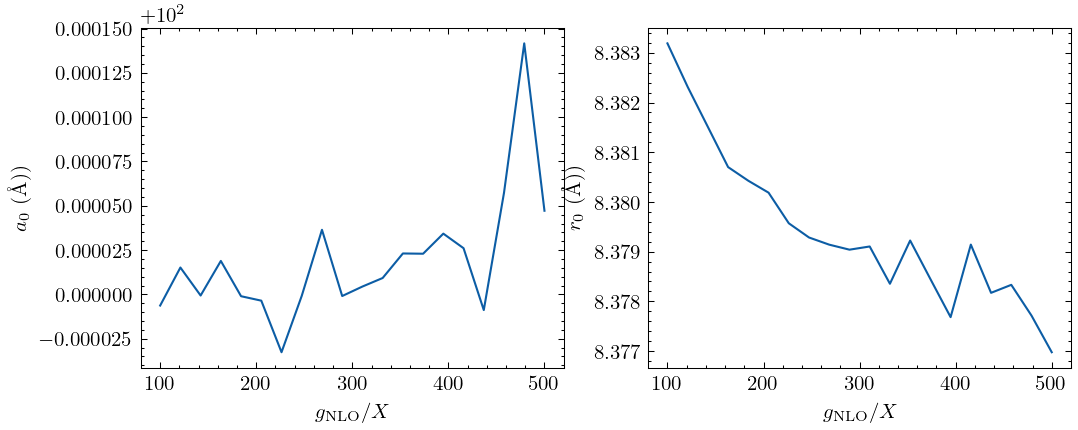

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

ax[0].plot(g_nlo_test/X, test_results[:, 0])
ax[1].plot(g_nlo_test/X, test_results[:, 1])

ax[0].set_xlabel(r'$g_{\rm NLO}/X$')
ax[0].set_ylabel(r'$a_0$ (Å))')

ax[1].set_xlabel(r'$g_{\rm NLO}/X$')
ax[1].set_ylabel(r'$r_0$ (Å))');

In [9]:
for i in range(nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.minimize(kcd_diff, guess, args=(s))
    gs = result.x
    a0, r0 = s.a0_and_r0(*gs, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-2 and np.abs((he4.R0 - r0)/he4.R0) < 1e-2:
        e2s = s.bound_state_spectrum(*gs)
        g_los[i] = gs[0]
        g_nlos[i] = gs[1]
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = gs
    else:
        break

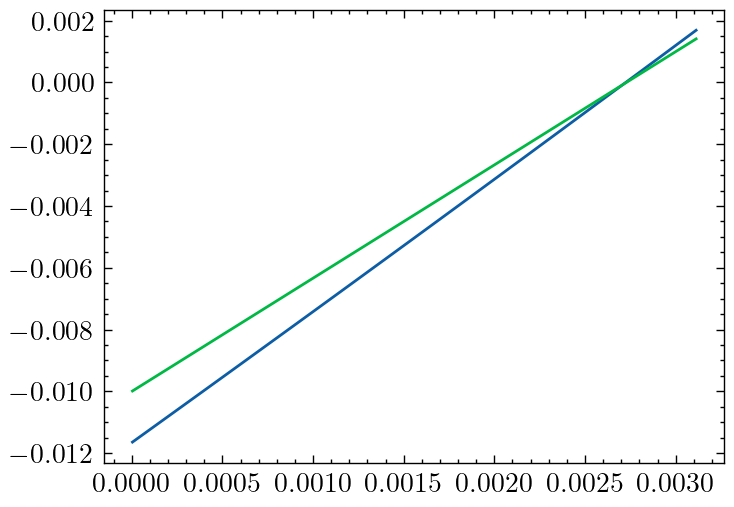

In [12]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(momenta**2, s.kcotd_gen_fast(momenta, *gs))
ax.plot(momenta**2, KCD);

In [7]:
restart = 2
s = he4.construct_helium4_system(Rs[restart], ELL)

In [8]:
guess = -2200*X
inverse_a0_diff(guess, s)

0.011628295276288475

In [9]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
    else:
        break

i = 2  R = 2.3952029265410713  g = -2.1799e+03 X  a0 = 1.0000e+02  r0 = 7.9727e+00  b2 = 0.0013214408847803851
i = 3  R = 2.2713131199958436  g = 1.3034e+02 X  a0 = 1.0000e+02  r0 = 7.8292e+00  b2 = 0.0013191038331283743
i = 4  R = 2.1596091960616217  g = 4.8941e+02 X  a0 = 1.0000e+02  r0 = 7.7232e+00  b2 = 0.0013173873169407763
i = 5  R = 2.0583775149962333  g = 7.1346e+02 X  a0 = 1.0000e+02  r0 = 7.6482e+00  b2 = 0.0013161765744706488
i = 6  R = 1.9662113576083418  g = 9.0763e+02 X  a0 = 1.0000e+02  r0 = 7.5979e+00  b2 = 0.0013153667611003478
i = 7  R = 1.8819451565679846  g = 1.0975e+03 X  a0 = 1.0000e+02  r0 = 7.5666e+00  b2 = 0.0013148625513397642
i = 8  R = 1.8046049446542318  g = 1.2927e+03 X  a0 = 1.0000e+02  r0 = 7.5490e+00  b2 = 0.0013145783506912495
i = 9  R = 1.7333705389441965  g = 1.4981e+03 X  a0 = 1.0000e+02  r0 = 7.5403e+00  b2 = 0.0013144388604214492
i = 10  R = 1.6675463412627713  g = 1.7169e+03 X  a0 = 1.0000e+02  r0 = 7.5367e+00  b2 = 0.0013143801973354624
i = 11  

In [10]:
restart = 20
s = he4.construct_helium4_system(Rs[restart], ELL)

In [25]:
guess = 5200*X
inverse_a0_diff(guess, s)

0.01756929408829582

In [27]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = g
    else:
        break

i = 20  R = 1.2085886326583386  g = 5.2006e+03 X  a0 = 1.0000e+02  r0 = 7.3942e+00  b2 = 0.0013121079582042146
i = 21  R = 1.1762157228549903  g = 5.8092e+03 X  a0 = 1.0000e+02  r0 = 7.3681e+00  b2 = 0.0013116937950748658
i = 22  R = 1.1455318344326864  g = 6.5581e+03 X  a0 = 1.0000e+02  r0 = 7.3427e+00  b2 = 0.0013112929731866894
i = 23  R = 1.1164081437267706  g = 7.5732e+03 X  a0 = 1.0000e+02  r0 = 7.3189e+00  b2 = 0.001310916807813701
i = 24  R = 1.0887286029732142  g = 9.2501e+03 X  a0 = 1.0000e+02  r0 = 7.2972e+00  b2 = 0.00131057412079892
i = 25  R = 1.0623883948367656  g = 1.3829e+04 X  a0 = 1.0000e+02  r0 = 7.2780e+00  b2 = 0.0013102710635809318


In [28]:
restart = 26
s = he4.construct_helium4_system(Rs[restart], ELL)

In [38]:
guess = -40000*X
inverse_a0_diff(guess, s)

0.014427023535276869

In [39]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = g
    else:
        break

i = 26  R = 1.0372926059823537  g = -3.8923e+04 X  a0 = 1.0000e+02  r0 = 7.2615e+00  b2 = 0.0013100111334430663
i = 27  R = 1.0133550843058379  g = 1.4832e+03 X  a0 = 1.0000e+02  r0 = 7.2478e+00  b2 = 0.0013097954390147329
i = 28  R = 0.9904974508252551  g = 4.6927e+03 X  a0 = 1.0000e+02  r0 = 7.2369e+00  b2 = 0.0013096229901129013
i = 29  R = 0.9686482423511685  g = 6.2308e+03 X  a0 = 1.0000e+02  r0 = 7.2285e+00  b2 = 0.001309491010550352
i = 30  R = 0.9477421651781218  g = 7.3277e+03 X  a0 = 1.0000e+02  r0 = 7.2224e+00  b2 = 0.001309395414593954
i = 31  R = 0.9277194433785839  g = 8.2575e+03 X  a0 = 1.0000e+02  r0 = 7.2183e+00  b2 = 0.0013093311560888024
i = 32  R = 0.9085252479983373  g = 9.1166e+03 X  a0 = 1.0000e+02  r0 = 7.2159e+00  b2 = 0.0013092925929792864
i = 33  R = 0.8901091956740469  g = 9.9480e+03 X  a0 = 1.0000e+02  r0 = 7.2147e+00  b2 = 0.001309273863222863
i = 34  R = 0.872424907018271  g = 1.0774e+04 X  a0 = 1.0000e+02  r0 = 7.2144e+00  b2 = 0.0013092691650489956
i = 

In [40]:
import matplotlib.pyplot as plt

plt.style.use('science')
gr = 4/3
h = 3

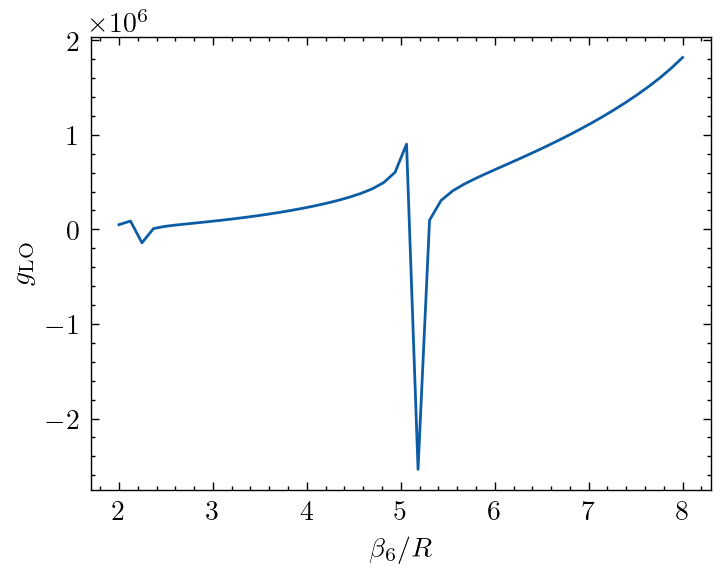

In [51]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, gs)

ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

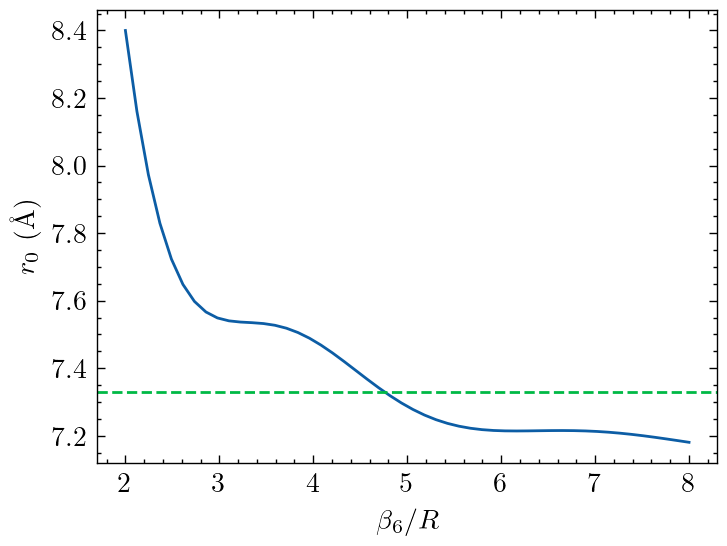

In [52]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, r0s)
ax.axhline(he4.R0, color='C1', linestyle='--')

ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$r_0$ (Å)');

In [53]:
np.savetxt('datfiles/he4_LO_nonlocal_rg_flow.txt', np.vstack((Rs, gs)).T, header='R (Å)  g ()')

In [54]:
np.savetxt('datfiles/he4_LO_nonloca_r0s.txt', np.vstack((Rs, r0s)).T, header='R (Å)  r_0 (Å)')